# Revisiting bit collisions in Morgan fingerprints with a larger dataset

This is an updated and revised version of an [old post](http://rdkit.blogspot.com/2016/02/colliding-bits-iii.html)

I looked at the number of collisions in Morgan fingerprints in an [earlier post](http://rdkit.blogspot.ch/2014/02/colliding-bits.html). The topic came up again in discussions about the recent post on [Morgan fingerprint stats](http://rdkit.blogspot.ch/2016/02/morgan-fingerprint-bit-statistics.html), which used a much larger data set. 

Here we repeat earlier collision analysis, usting the larger dataset. I will look at fingerprints with different radii -- 1, 2, and 3 -- folded to a set of different sizes -- 1K, 2K, 4K, 8K, 16K.

TL;DR version: The conclusions match what we observed before, there are a fair number of collisions at fingerprint sizes below 4K. As expected, higher radii have more collisions. 

In [1]:
from rdkit import Chem,DataStructs
import time,random,gzip,pickle,copy
import numpy as np
from collections import defaultdict
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
%pylab inline
plt.style.use('tableau-colorblind10')
print(rdkit.__version__)
import time
print(time.asctime())

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
2022.09.1
Sun Jan 15 05:58:20 2023


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


For test data I'll use the 4 million random compounds from PubChem with <=50 heavy atoms. I constructed the set of compounds by downloading the [full pubchem compound set](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-SMILES.gz) (on 8 Jan, 2023), and picking 10 million random lines using an [awk script](https://stackoverflow.com/a/692401).

In [2]:
filen='/localhome/glandrum/Datasets/PubChem/pubchem_compound_random_10000000.txt.gz'

Loop over the molecules and build fingerprints of multiple radii and folded lengths.

In [3]:
gens = [('mfp1',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=1,fpSize=fpsize)),
        ('mfp2',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpsize)),
         ('mfp3',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=fpsize)),
         ('rdk5',lambda fpsize: rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=fpsize)),
         ('hashap',lambda fpsize: rdFingerprintGenerator.GetAtomPairGenerator(fpSize=fpsize)),
         ('hashtt',lambda fpsize: rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=fpsize)),
         ]

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import copy
history={} # we will use this to see how quickly the results converge
counts=defaultdict(lambda:defaultdict(int))
t1 = time.time()
i = 0
with gzip.open(filen,'rb') as inf:
    for inl in inf:
        try:
            nm,smi = inl.strip().split()
        except:
            break
        m = Chem.MolFromSmiles(smi)
        if m is None or m.GetNumHeavyAtoms()>50:
            continue
        i+=1
        for nm,fpg in gens:
            fpgen = fpg(1024) # doesn't matter here
            onbits=len(fpgen.GetSparseFingerprint(m).GetOnBits())
            counts[nm][onbits]+=1
            for l in 64,128,256,512,1024,2048,4096,8192,16384:
                fpnm = f'{nm}-{l}'
                fpgen = fpg(l)
                dbits = onbits-fpgen.GetFingerprint(m).GetNumOnBits()
                counts[fpnm][dbits]+=1
        if not i%50000:
            t2 = time.time()
            print(f"Done {i} in {t2-t1:.2f} sec")
        if not i%100000:
            history[i] = copy.deepcopy(counts)
        if i>=4000000:
            break

Done 50000 in 214.60 sec
Done 100000 in 475.92 sec
Done 150000 in 790.69 sec
Done 200000 in 1065.40 sec
Done 250000 in 1350.49 sec
Done 300000 in 1663.03 sec
Done 350000 in 1979.41 sec
Done 400000 in 2289.94 sec
Done 450000 in 2584.58 sec
Done 500000 in 2889.27 sec
Done 550000 in 3156.72 sec
Done 600000 in 3416.83 sec
Done 650000 in 3673.20 sec
Done 700000 in 3930.41 sec
Done 750000 in 4232.50 sec
Done 800000 in 4518.37 sec
Done 850000 in 4788.19 sec
Done 900000 in 5080.44 sec
Done 950000 in 5272.51 sec
Done 1000000 in 5507.97 sec
Done 1050000 in 5831.47 sec
Done 1100000 in 6124.22 sec
Done 1150000 in 6405.13 sec
Done 1200000 in 6699.62 sec
Done 1250000 in 7004.17 sec
Done 1300000 in 7264.67 sec
Done 1350000 in 7525.13 sec
Done 1400000 in 7779.24 sec
Done 1450000 in 8045.30 sec
Done 1500000 in 8314.90 sec
Done 1550000 in 8643.98 sec
Done 1600000 in 8978.91 sec
Done 1650000 in 9292.37 sec
Done 1700000 in 9596.19 sec
Done 1750000 in 9854.10 sec
Done 1800000 in 10134.48 sec
Done 1850000 i

In [9]:
counts.keys()

dict_keys(['mfp1', 'mfp1-64', 'mfp1-128', 'mfp1-256', 'mfp1-512', 'mfp1-1024', 'mfp1-2048', 'mfp1-4096', 'mfp1-8192', 'mfp1-16384', 'mfp2', 'mfp2-64', 'mfp2-128', 'mfp2-256', 'mfp2-512', 'mfp2-1024', 'mfp2-2048', 'mfp2-4096', 'mfp2-8192', 'mfp2-16384', 'mfp3', 'mfp3-64', 'mfp3-128', 'mfp3-256', 'mfp3-512', 'mfp3-1024', 'mfp3-2048', 'mfp3-4096', 'mfp3-8192', 'mfp3-16384', 'rdk5', 'rdk5-64', 'rdk5-128', 'rdk5-256', 'rdk5-512', 'rdk5-1024', 'rdk5-2048', 'rdk5-4096', 'rdk5-8192', 'rdk5-16384', 'hashap', 'hashap-64', 'hashap-128', 'hashap-256', 'hashap-512', 'hashap-1024', 'hashap-2048', 'hashap-4096', 'hashap-8192', 'hashap-16384', 'hashtt', 'hashtt-64', 'hashtt-128', 'hashtt-256', 'hashtt-512', 'hashtt-1024', 'hashtt-2048', 'hashtt-4096', 'hashtt-8192', 'hashtt-16384'])

In [10]:
pickle.dump(dict(counts),gzip.open('../data/fp_collision_counts.pkl.gz','wb+'))

In [11]:
for k,d in history.items():
    history[k] = dict(d)
pickle.dump(dict(history),gzip.open('../data/fp_collision_counts.history.pkl.gz','wb+'))

In [19]:
with gzip.open('../data/fp_collision_counts.pkl.gz','rb') as inf:
    counts = pickle.load(inf)
with gzip.open('../data/fp_collision_counts.history.pkl.gz','rb') as inf:
    history = pickle.load(inf)

Now plot histograms of the numbers of collisions along with the distributions of the number of bits set in the non-folded FPs

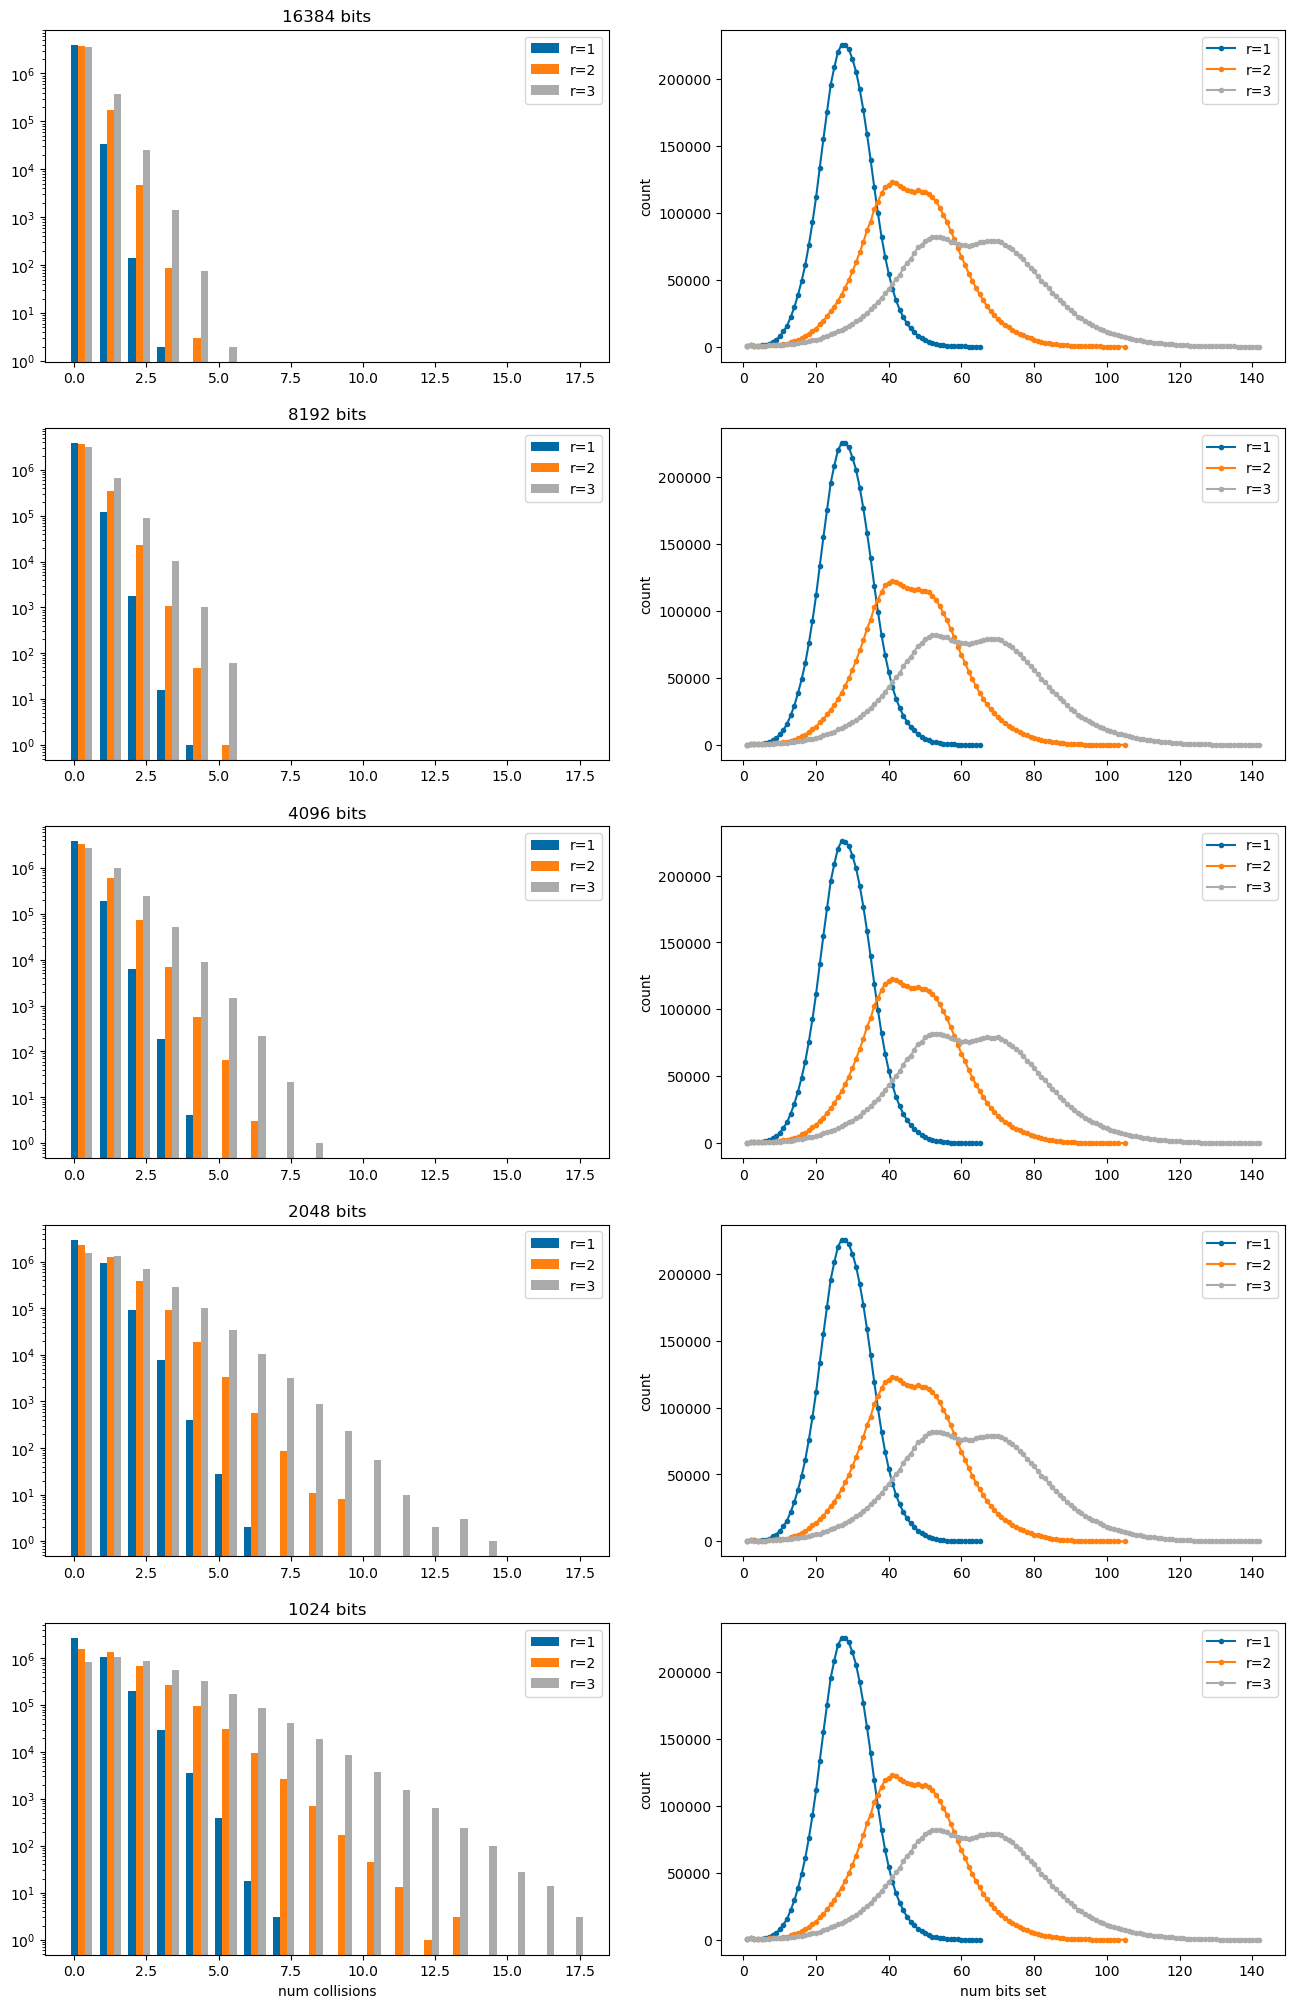

In [53]:
allCounts = (16384, 8192,4096,2048,1024,) #512,256,128,64)

figure(figsize=(16,5*len(allCounts)))

pidx=1
#----------------------------
for nbits in allCounts:
    subplot(len(allCounts),2,pidx)
    pidx+=1
    maxCollisions = max(counts[f'mfp3-{allCounts[-1]}'].keys())+1
    d1=np.zeros(maxCollisions,int)
    for k,v in counts[f'mfp1-{nbits}'].items():
        d1[k]=v
    d2=np.zeros(maxCollisions,int)
    for k,v in counts[f'mfp2-{nbits}'].items():
        d2[k]=v
    d3=np.zeros(maxCollisions,int)
    for k,v in counts[f'mfp3-{nbits}'].items():
        d3[k]=v
    barWidth=.25
    locs = np.array(range(maxCollisions))

    bar(locs,d1,barWidth,label="r=1")
    bar(locs+barWidth,d2,barWidth,label="r=2")
    bar(locs+2*barWidth,d3,barWidth,label="r=3")
    
    #_=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=yscale("log")
    _=legend()
    if nbits == allCounts[-1]:
        xlabel('num collisions')
    
    subplot(len(allCounts),2,pidx)
    pidx+=1
    itms = list(sorted(counts['mfp1'].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=1")
    itms = list(sorted(counts['mfp2'].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=2")
    itms = list(sorted(counts['mfp3'].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=3")
    if nbits == allCounts[-1]:
        _=xlabel("num bits set")
    _=ylabel("count")
    _=legend()
    
    

So, there are definitely some collisions, particularly with radius 3 fingerprints with 1K bits.

Look the short Morgan fingerprints

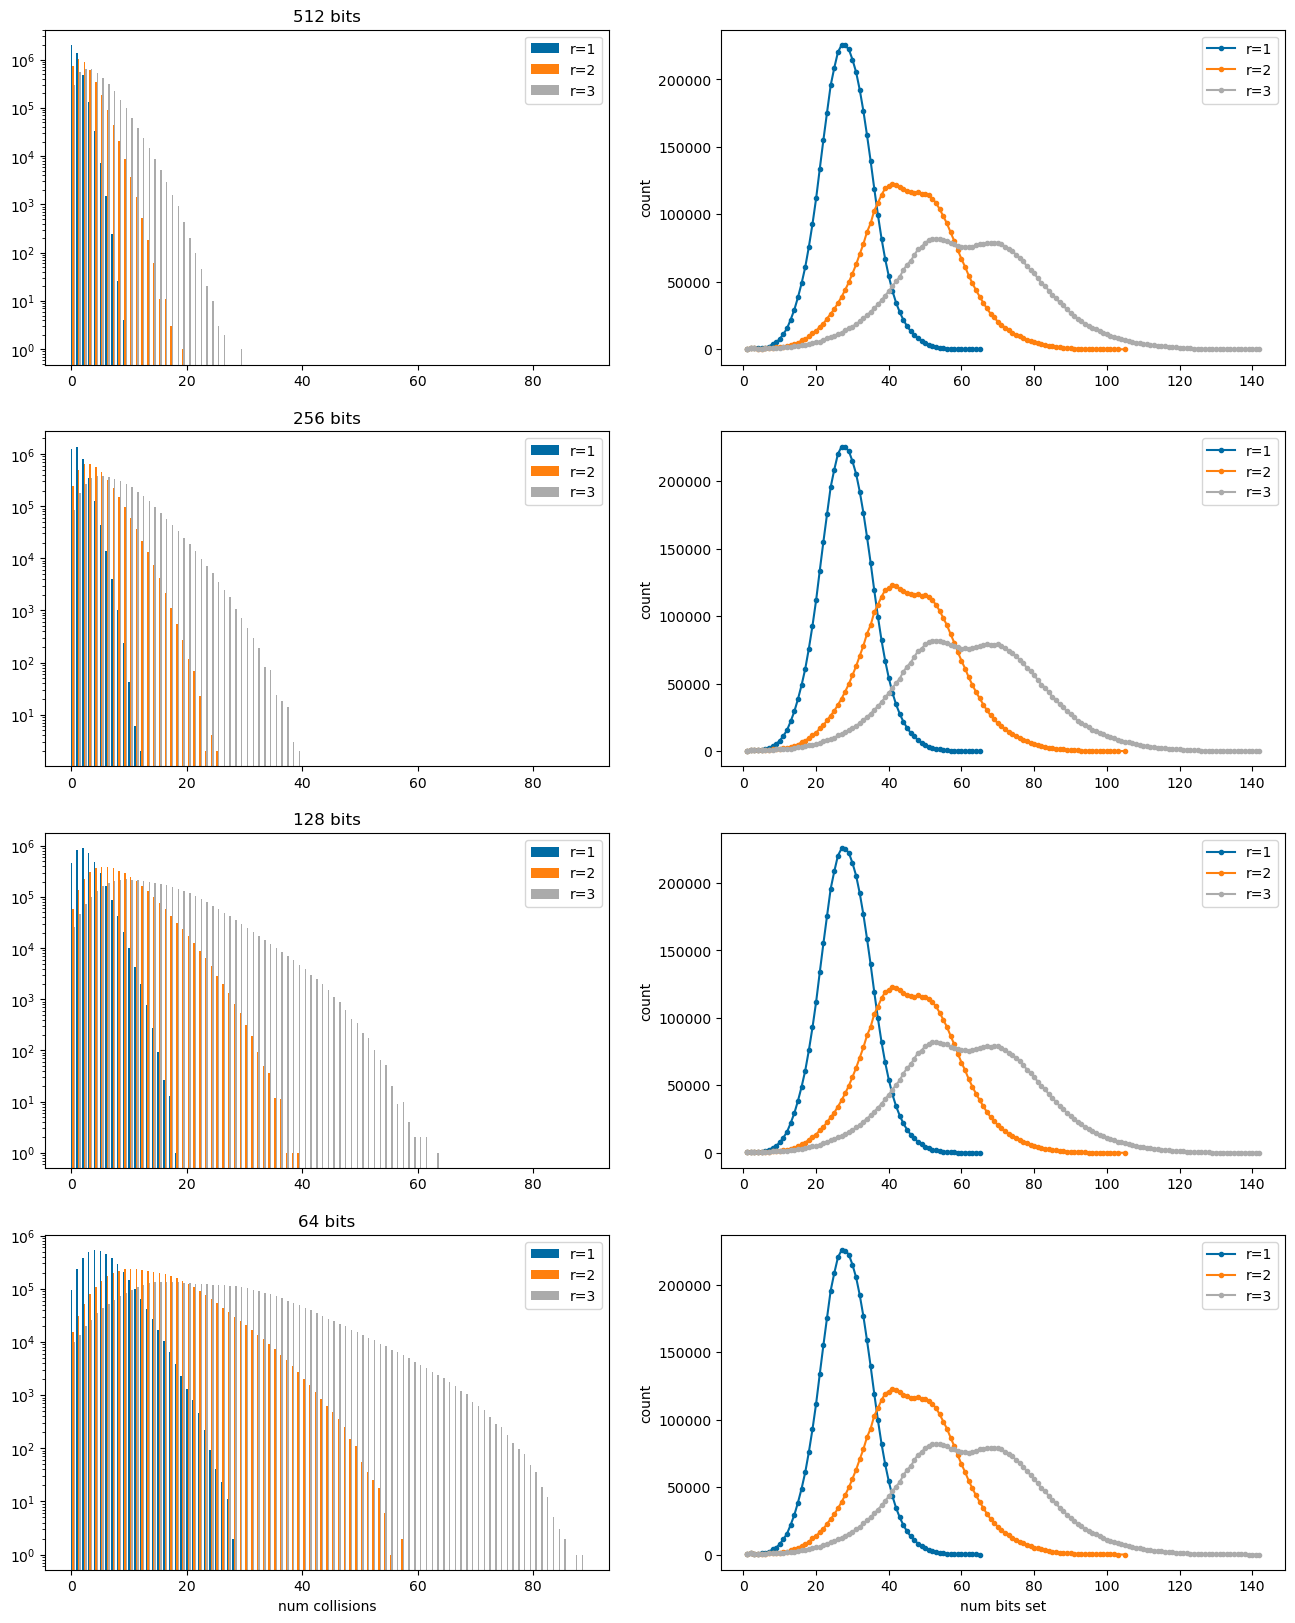

In [52]:
allCounts = (512,256,128,64)

figure(figsize=(16,5*len(allCounts)))

pidx=1
#----------------------------
for nbits in allCounts:
    subplot(len(allCounts),2,pidx)
    pidx+=1
    maxCollisions = max(counts[f'mfp3-{allCounts[-1]}'].keys())+1
    d1=np.zeros(maxCollisions,int)
    for k,v in counts[f'mfp1-{nbits}'].items():
        d1[k]=v
    d2=np.zeros(maxCollisions,int)
    for k,v in counts[f'mfp2-{nbits}'].items():
        d2[k]=v
    d3=np.zeros(maxCollisions,int)
    for k,v in counts[f'mfp3-{nbits}'].items():
        d3[k]=v
    barWidth=.25
    locs = np.array(range(maxCollisions))

    bar(locs,d1,barWidth,label="r=1")
    bar(locs+barWidth,d2,barWidth,label="r=2")
    bar(locs+2*barWidth,d3,barWidth,label="r=3")
    
    #_=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=yscale("log")
    _=legend()
    if nbits == allCounts[-1]:
        xlabel('num collisions')

    subplot(len(allCounts),2,pidx)
    pidx+=1
    itms = list(sorted(counts['mfp1'].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=1")
    itms = list(sorted(counts['mfp2'].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=2")
    itms = list(sorted(counts['mfp3'].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=3")
    if nbits == allCounts[-1]:
        _=xlabel("num bits set")
    _=ylabel("count")
    _=legend()
    
    

Look at the other fingerprint types.
We'll do this a little differently because of the scales.

Start with the number of bits set:

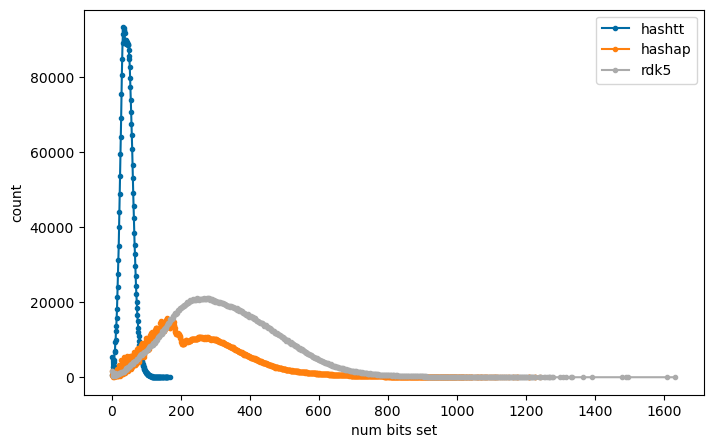

In [56]:
figsize(8,5)

itms = list(sorted(counts['hashtt'].items()))
plot([x for x,y in itms],[y for x,y in itms],'.-',label=
    "hashtt")
itms = list(sorted(counts['hashap'].items()))
plot([x for x,y in itms],[y for x,y in itms],'.-',label=
    "hashap")
itms = list(sorted(counts['rdk5'].items()))
plot([x for x,y in itms],[y for x,y in itms],'.-',label=
    "rdk5")
if nbits == allCounts[-1]:
    _=xlabel("num bits set")
_=ylabel("count")
_=legend()
    
    

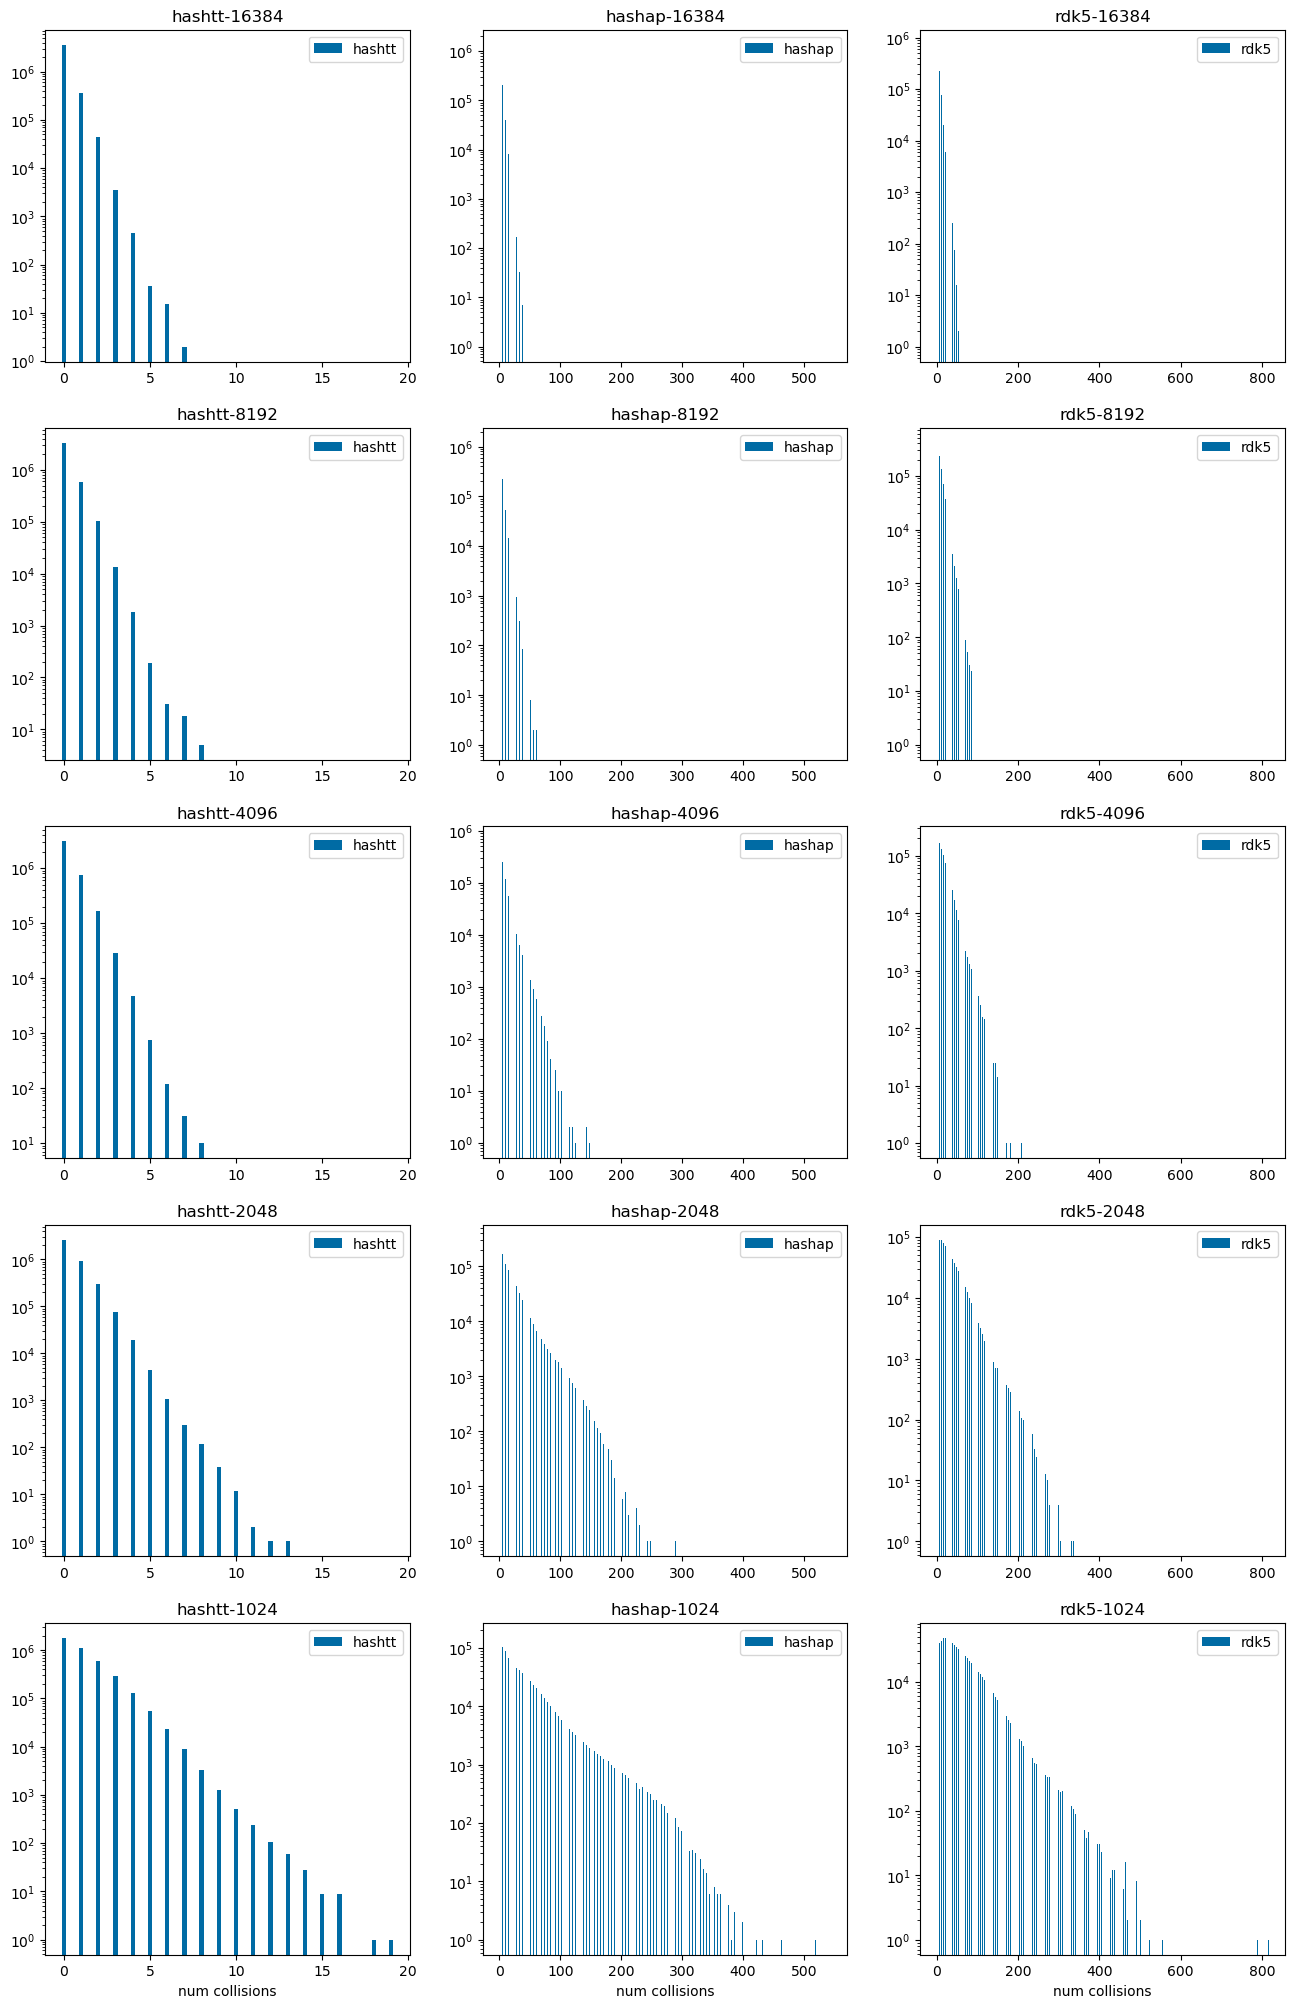

In [57]:
allCounts = (16384, 8192,4096,2048,1024,) #512,256,128,64)

figure(figsize=(16,5*len(allCounts)))

pidx=1
#----------------------------
for nbits in allCounts:
    for fpt in ('hashtt','hashap','rdk5'):
        subplot(len(allCounts),3,pidx)
        pidx+=1
        maxCollisions = max(counts[f'{fpt}-{allCounts[-1]}'].keys())+1
        d1=np.zeros(maxCollisions,int)
        for k,v in counts[f'{fpt}-{nbits}'].items():
            d1[k]=v
        barWidth=.25
        locs = np.array(range(maxCollisions))

        bar(locs,d1,barWidth,label=fpt)    
        title(f'{fpt}-{nbits}')
        _=yscale("log")
        _=legend()
        if nbits == allCounts[-1]:
            xlabel('num collisions')


The topological torsion FPs don't have a huge number of collisions, but both atom pair and RDKit fingerprints really do have collisions, as one would expect given the number of set bits.

Look at the percentage of compounds with <= a particular number of collisions

In [59]:
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
ccounts = list(range(11))


row = ('length','fingerprint',)+tuple(str(x) for x in ccounts)
divider = ['-'*len(k) for k in row]
print('| '+' | '.join(row)+' |')
print('| '+' | '.join(divider)+' |')

for bc in reversed(bcounts):
    for nm,fpg in gens:
        row = [str(bc),nm]
        fpn = f'{nm}-{bc}'
        nmols = np.sum(np.fromiter((x for x in counts[fpn].values()),int))
        accum = 0
        for ccount in ccounts:
            accum += counts[fpn].get(ccount,0)
            row.append(f'{accum/nmols:.3f}')
        print('| '+' | '.join(row)+' |')
            

| length | fingerprint | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| ------ | ----------- | - | - | - | - | - | - | - | - | - | - | -- |
| 16384 | mfp1 | 0.991 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 16384 | mfp2 | 0.956 | 0.999 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 16384 | mfp3 | 0.900 | 0.993 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 16384 | rdk5 | 0.181 | 0.332 | 0.460 | 0.566 | 0.654 | 0.724 | 0.780 | 0.826 | 0.863 | 0.892 | 0.916 |
| 16384 | hashap | 0.335 | 0.519 | 0.651 | 0.746 | 0.816 | 0.867 | 0.905 | 0.931 | 0.950 | 0.964 | 0.974 |
| 16384 | hashtt | 0.898 | 0.988 | 0.999 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 8192 | mfp1 | 0.969 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 8192 | mfp2 | 0.906 | 0.994 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 8192 | mfp3 | 0.

# Impact on similarity

Now that we have a sense of how many collisions there are, lets look at the impact those collisions have on molecular similarity. 

As a data set we'll use a set of 25000 pairs of ChEMBL molecules with an MFP1 similarity of at least 0.6.


In [24]:
pairs = []
for l in gzip.open('../data/chembl21_25K.mfp1.pairs.txt.gz','rt'):
    l = l.split()
    pairs.append([Chem.MolFromSmiles(l[1]),Chem.MolFromSmiles(l[3])])

In [35]:
sims = defaultdict(list)
for nm,fpgen in gens:
    print(f'Doing {nm}')
    fpg = fpgen(1024) # size is irrelevant here
    for m1,m2 in pairs:
        fp1 = fpg.GetSparseFingerprint(m1)
        fp2 = fpg.GetSparseFingerprint(m2)
        sims[nm].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    for l in 64,128,256,512,1024,2048,4096,8192,16384:
        fpn = f'{nm}-{l}'
        fpg = fpgen(l)
        for m1,m2 in pairs:
            fp1 = fpg.GetFingerprint(m1)
            fp2 = fpg.GetFingerprint(m2)
            sims[fpn].append(DataStructs.TanimotoSimilarity(fp1,fp2))


Doing mfp1
Doing mfp2
Doing mfp3
Doing rdk5
Doing hashap
Doing hashtt


In [36]:
pickle.dump(dict(sims),gzip.open('../data/fp_collision_sims.pkl.gz','wb+'))

In [37]:
sims['mfp1-16384']

[0.59375,
 0.53125,
 0.6842105263157895,
 0.696969696969697,
 0.6785714285714286,
 0.6,
 0.5588235294117647,
 0.42857142857142855,
 0.45714285714285713,
 0.5609756097560976,
 0.6296296296296297,
 0.525,
 0.68,
 0.7105263157894737,
 0.46153846153846156,
 0.6857142857142857,
 0.631578947368421,
 0.7272727272727273,
 0.6585365853658537,
 0.5806451612903226,
 0.6857142857142857,
 0.5882352941176471,
 0.6296296296296297,
 0.41025641025641024,
 0.5614035087719298,
 0.6904761904761905,
 0.8979591836734694,
 0.6052631578947368,
 0.9393939393939394,
 0.5357142857142857,
 0.5135135135135135,
 0.6944444444444444,
 0.5,
 0.7045454545454546,
 0.5357142857142857,
 0.4722222222222222,
 0.5333333333333333,
 0.7741935483870968,
 0.5238095238095238,
 0.5714285714285714,
 0.5675675675675675,
 0.5882352941176471,
 0.6666666666666666,
 0.7777777777777778,
 0.5862068965517241,
 0.5,
 0.5357142857142857,
 0.7906976744186046,
 0.5121951219512195,
 0.6451612903225806,
 0.7906976744186046,
 0.6521739130434783,


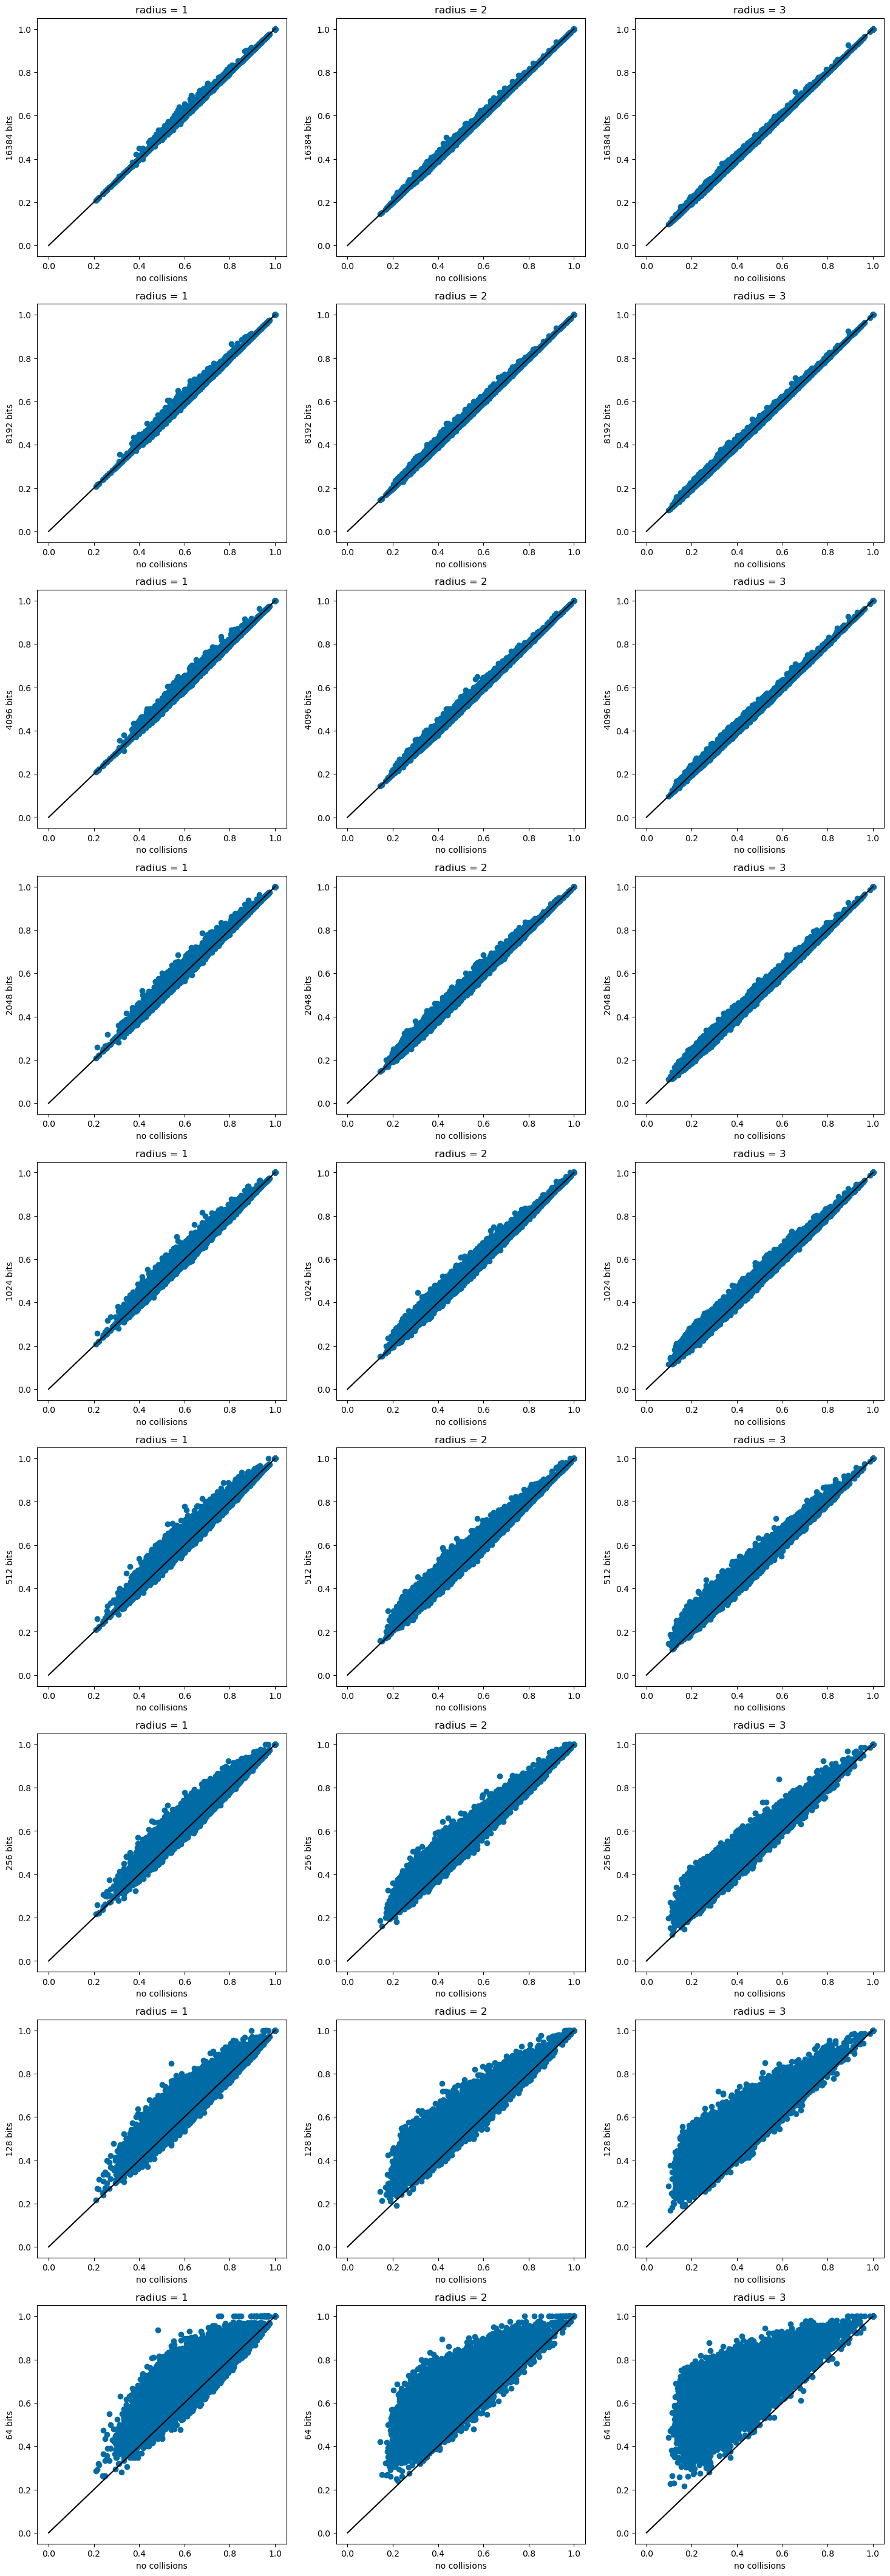

In [38]:
rads = (1,2,3)
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
figsize(3*6,len(bcounts)*6)

plt = 1
for i,cnt in enumerate(reversed(bcounts)):
    for j,rad in enumerate(rads):
        subplot(len(bcounts),3,plt)
        plt += 1
        scatter(sims[f'mfp{rad}'],sims[f'mfp{rad}-{cnt}'])
        plot((0,1),(0,1),'k-')
        xlabel('no collisions')
        ylabel(f'{cnt} bits')
        title(f'radius = {rad}')

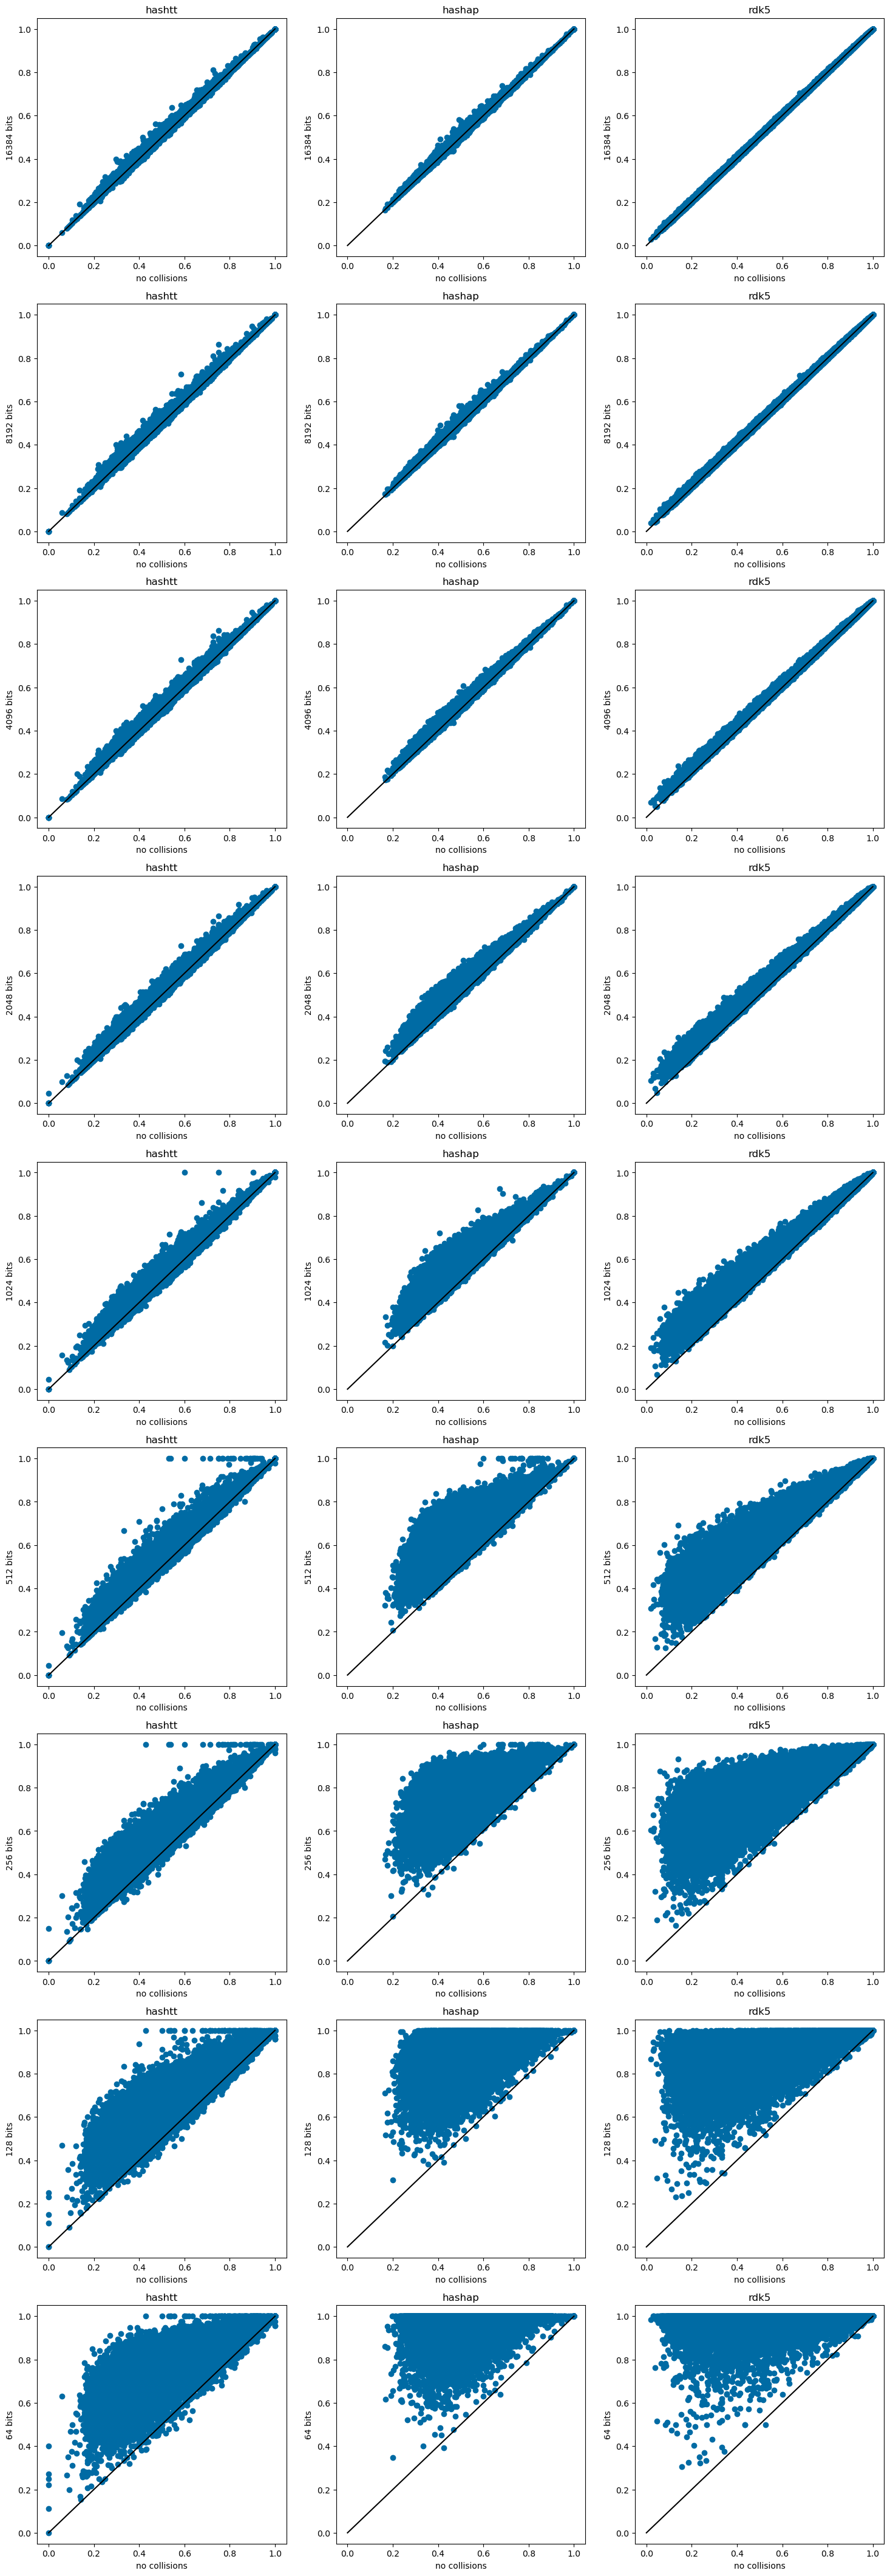

In [41]:
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
figsize(3*6,len(bcounts)*6)

plt = 1
for i,cnt in enumerate(reversed(bcounts)):
    for j,nm in enumerate(('hashtt','hashap','rdk5')):
        subplot(len(bcounts),3,plt)
        plt += 1
        scatter(sims[f'{nm}'],sims[f'{nm}-{cnt}'])
        plot((0,1),(0,1),'k-')
        xlabel('no collisions')
        ylabel(f'{cnt} bits')
        title(f'{nm}')

In [43]:
from scipy.stats import spearmanr

row = ('radius','fingerprint','SpearmanR','mean(d)','std(d)','90% |d|')
divider = ['-'*len(k) for k in row]
print('| '+' | '.join(row)+' |')
print('| '+' | '.join(divider)+' |')
        

rads = (1,2,3)
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
for i,cnt in enumerate(reversed(bcounts)):
    for j,(nm,fpg) in enumerate(gens):
        d1 = numpy.array(sims[nm])
        d2 = numpy.array(sims[f'{nm}-{cnt}'])
        delt = d2-d1
        row = [str(cnt),nm,f'{spearmanr(d1,d2).correlation:.3f}',f'{np.mean(delt):.2g}',
               f'{np.std(delt):.2g}',f'{np.quantile(np.abs(delt),0.9):.2g}']
        print('| '+' | '.join(row)+' |')

| radius | fingerprint | SpearmanR | mean(d) | std(d) | 90% |d| |
| ------ | ----------- | --------- | ------- | ------ | ------- |
| 16384 | mfp1 | 1.000 | 0.0002 | 0.0025 | 0 |
| 16384 | mfp2 | 1.000 | 0.00074 | 0.0037 | 0 |
| 16384 | mfp3 | 1.000 | 0.0012 | 0.0038 | 0.0053 |
| 16384 | rdk5 | 1.000 | 0.0046 | 0.0045 | 0.011 |
| 16384 | hashap | 0.998 | 0.0054 | 0.0069 | 0.014 |
| 16384 | hashtt | 0.999 | 0.002 | 0.007 | 0.009 |
| 8192 | mfp1 | 0.999 | 0.00071 | 0.0048 | 0 |
| 8192 | mfp2 | 0.999 | 0.0014 | 0.0051 | 0.0068 |
| 8192 | mfp3 | 0.999 | 0.0024 | 0.0054 | 0.011 |
| 8192 | rdk5 | 1.000 | 0.0094 | 0.0076 | 0.02 |
| 8192 | hashap | 0.997 | 0.0072 | 0.0079 | 0.018 |
| 8192 | hashtt | 0.998 | 0.0038 | 0.0099 | 0.017 |
| 4096 | mfp1 | 0.998 | 0.0014 | 0.0067 | 0 |
| 4096 | mfp2 | 0.998 | 0.0028 | 0.0072 | 0.012 |
| 4096 | mfp3 | 0.998 | 0.0047 | 0.0076 | 0.016 |
| 4096 | rdk5 | 0.999 | 0.019 | 0.013 | 0.037 |
| 4096 | hashap | 0.993 | 0.017 | 0.013 | 0.036 |
| 4096 | hashtt | 0.9